*Alternative implementation of `generals1` (added randomness)*

### Extracted Story
~~Several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. Each general observes the enemy and communicates his observation to the others. Each general then combines all the reported observations into a single plan of action (i.e., “attack” or “retreat”), for example, by using a majority vote. Communicating only by messengers, the generals must agree upon a common, and reasonable battle plan, however, one or more of them may be traitors who will try to confuse the others. All loyal generals must carry out the same plan, whereas the traitors may do anything they wish.~~

### Extracted Story (verbatim)
We imagine that several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. The generals can communicate with one another only by messenger. After observing the enemy, they must decide upon a common plan of action. However, some of the generals may be traitors, trying to prevent the loyal generals from reaching agreement.
...
All loyal generals decide upon the same plan of action... but the traitors may do anything they wish.
...
They loyal generals should not only reach agreement, but should agree upon a reasonable plan.

*Everything below this point is based on the verbatim version of the story.*

### User Stories
* As a GENERAL I want to...
  * make observations on an enemy city to decide upon a plan of action.
  * be able to communicate with other genrals to share our observations.
* As a LOYAL GENERAL I want to...
  * decide upon a reasonable plan of action so that my division does what is best.
  * decide upon the same plan of action as all other loyal generals so order within the army is maintained.
* As a DISLOYAL GENERAL I want to...
  * make false or contradicting observations to prevent the loyal generals from reaching agreement.
* As a MESSENGER I want to...
  * deliver messages between generals/divisons so they can reach upon some agreement.

### Assumptions
* There is only one messenger.
* "Enemy" and "Enemy City" are taken to refer to the same idea.
* A "reasonable plan" is assumed to mean that which wins a majority vote.
* The enemy/city is taken to have no functionality other than just "existing".
  * Whether a city is "attackable" or not is now dependent on each general, i.e., each general cana make a different observation.
* A traitorous general makes random observations to each other general in an attmpt to confuse the loyal generals.
* The observations that generals can make are either "attack" or "retreat".

### Design Decisions
* Enemy cities are simply instances of a class that essentially does nothing (yet).
* Each general works by first making an "objective" decision on an enemy. This is his true observation and not necessarily the one he communicates to the others.
* Generals make "random" observations on a city.
* Traitorous generals randomise the decision that they communicate to others.
* There is (still) no tie breaker for the majority vote... It's not really needed here due to the randomness.

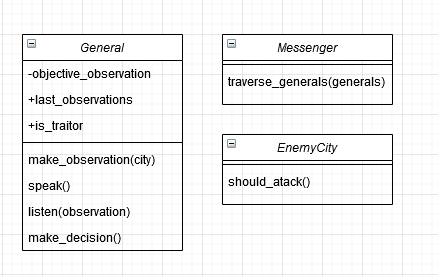

### Interesting Observations
Now that the traitors make random observations to all other generals, the consistency that was previously present is now gone. As a rsult, there is no need for a tie breaker when making decisions. It is now possible for the loyal generals to not reach an agreement. However, we now have the opposite problem as a result of the introduced randomness - now that the *loyal* generals make different observations on the same city, they sometimes (often) fail to reach an agreement even when their decision is **not** affected by the traitors. This is either realistic or not depending on how you look at it. It is intersting to note that if we keep the previous logic whereby traitors simply lied, this problem is somewhat (not completely) alleviated. In such an implementation there is still some randomness because the initial observation that each general makes is random.

In [183]:
import random
from itertools import combinations
from collections import Counter, defaultdict

In [184]:
LOG_COMMUNICATIONS = True  # Display the communication network between generals (this can get messy!)
TOTAL_GENERALS = 30
PERCENTAGE_TRAITORS = 0.2  # -1 for random

In [185]:
class EnemyCity:
    @property
    def should_attack(self):
        return random.choice([True, False])

In [186]:
class General:
    def __init__(self, is_traitor=False):
        self._objective_observation = None
        self.last_observations = []
        self.is_traitor = is_traitor
    
    def make_observation(self, city: EnemyCity):
        self._objective_observation = ('retreat', 'attack')[city.should_attack]
    
    def speak(self):
        if not self.is_traitor:
            return self._objective_observation
        
        # Traitors return a random observation
        return random.choice(['retreat', 'attack'])
    
    def listen(self, observation):
        self.last_observations.append(observation)
    
    def make_decision(self):
        return Counter(self.last_observations).most_common(1)[0][0]

In [187]:
class Messenger:
    @staticmethod
    def traverse_generals(generals):
        # {General: {target: message, ...}}
        comms = defaultdict(dict)
        
        for x, y in combinations(generals, 2):
            y_speak = y.speak()
            x_speak = x.speak()
            
            x.listen(y_speak)
            y.listen(x_speak)
            
            comms[y][x] = y_speak
            comms[x][y] = x_speak
        
        return comms

In [188]:
def main():
    if PERCENTAGE_TRAITORS != -1:
        num_traitors = int(TOTAL_GENERALS * PERCENTAGE_TRAITORS)
    else:
        num_traitors = int(TOTAL_GENERALS * random.random())
    
    generals = [General(False) for _ in range(TOTAL_GENERALS - num_traitors)] + \
               [General(True) for _ in range(num_traitors)]
    
    # We now have just a single city object with no explicit `should_attack` argument
    city = EnemyCity()
    
    print(
        f'Running with {TOTAL_GENERALS} total generals of which {num_traitors} are traitorous.\n\n'
    )
    
    # Each general makes an objective observation
    for g in generals:
        g.make_observation(city)
    
    # Each general communicates his observation (or not)
    m = Messenger()
    communications = m.traverse_generals(generals)
    
    # Each general comes up with a plan of action
    loyal_poa = set()
    
    for x, g in enumerate(generals):
        decision = g.make_decision()
        
        if not g.is_traitor:
            loyal_poa.add(decision)
            
#         print(
#             f'General {g._id} {"(traitor)" if g.is_traitor else "(loyal)":>9}'
#             f' says {decision.upper():>7} based on {g.last_observations:}'
#         )
    
    if len(loyal_poa) != 1:
        print('Loyal Generals cannot agree on a plan of action!!!\n')
    else:
        print(f'Loyal Generals have agreed on: {loyal_poa.pop()}\n')
    
    if LOG_COMMUNICATIONS:
        for x, g in enumerate(communications):
            a, r = 0, 0
            
            for msg in communications[g].values():
                if msg == 'attack':
                    a += 1
                else:
                    r += 1
                    
            print(
                f'{"[!] " if g.is_traitor else ""}'
                f'General {x} has made the objective observation of {g._objective_observation.upper()}'
                f' and reported ATTTACK {a} times and RETREAT {r} times'
            )

In [189]:
if __name__ == '__main__':
    main()

Running with 30 total generals of which 6 are traitorous.


Loyal Generals cannot agree on a plan of action!!!

General 0 has made the objective observation of ATTACK and reported ATTTACK 29 times and RETREAT 0 times
General 1 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 2 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 3 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 4 has made the objective observation of ATTACK and reported ATTTACK 29 times and RETREAT 0 times
General 5 has made the objective observation of ATTACK and reported ATTTACK 29 times and RETREAT 0 times
General 6 has made the objective observation of ATTACK and reported ATTTACK 29 times and RETREAT 0 times
General 7 has made the objective observation of ATTACK and reported ATTTACK 29 times and RETREAT 0 times
General 8 has made the objective observation 